In [1]:
#import standard libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from random import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Flatten
import h5py
from tensorflow.python.keras.saving.hdf5_format import load_weights_from_hdf5_group
from prettytable import PrettyTable
import keras

In [2]:
#import project libs
from PowerAIDataHandler.PowerAIDataHandler import ClassPowerAIDataHandler

In [3]:
# Konfiguration der Geraete ueberschreiben 
#dh = ClassPowerAIDataHandler("C:/Users/Kids/iCloudDrive/Documents/GitHub/PowerAI/.env")
dh = ClassPowerAIDataHandler(".env")

dh.base_pow = 200
dh.device_list = {
    1: {'name' : 'espresso-machine', 'minpow' : 900, 'maxpow' : 1500},
    2: {'name' : 'washing-machine', 'minpow' : 1000, 'maxpow': 3000}, #min=500
    4: {'name' : 'dish-washer', 'minpow' : 600, 'maxpow': 2500},#1900
    #8: {'name' : 'induction-cooker', 'minpow' : 500, 'maxpow': 3500},
    #16: {'name': 'irrigation-system', 'minpow': 800, 'maxpow': 1500},
    32: {'name': 'oven', 'minpow': 800, 'maxpow': 5500},
    #64: {'name': 'microwave', 'minpow': 800, 'maxpow': 1500},
    #128: {'name': 'kitchen-light', 'minpow': 250, 'maxpow': 500},
    256: {'name': 'living-room-light', 'minpow': -dh.base_pow, 'maxpow': 2000}, # OKO for base load. some peaks in it, which are not shown in VZ
    #512: {'name': 'dining-room-light', 'minpow': 0, 'maxpow': 400}, #OKO data looks strange ...
    #1024: {'name': 'ground-floor-light', 'minpow': 400},
    #2048: {'name': 'upper-floor-light', 'minpow': 180},
}

In [62]:
#init parameters for neural network
num_devices       = len(dh.device_list)   #länge der Gerätliste
event_ratio       = 1 #Verhältnis Trainings-/Testdaten
window_length_max = 43 #maximale Anzahl an Daten die gleichzeitig eingespeist werden
epochs            = 1000 #Anzahl der Traings-/Testdurchläufe

In [5]:
#read the classified events from the mysql database
dh.read_events_from_db()

#print timeserie of the events
#dh.print_events() #print all
#dh.print_events(1) #print all espresso
#dh.print_events(1,1) #print first event of espresso

In [6]:
#exclude power values below certain device-specific threshold
dh.filter_events_by_minpow()

#dh.print_events() #print all
#dh.print_events(1) #print all espresso
#dh.print_events(1,1) #print first event of espresso

In [45]:
# Erstelle Trainingsdaten für das Neuronale Netz
train_x, train_y = dh.generate_training_data_from_events(window_length_max, event_ratio) #fk: aufteilen der Daten

chosen window_length: 43
available data points for 1 (espresso-machine): 23271
available data points for 2 (washing-machine): 16277
available data points for 4 (dish-washer): 23978
available data points for 32 (oven): 24088
available data points for 256 (living-room-light): 105033
self.min_device_dps: 16277
self.device_ids_order: [  1.   2.   4.  32. 256.]
z-normalization gives mean = 1.3429231476898165e-16 and std = 1.0000000000000002
randomized batches
train_x (batch num, window length): (1890, 43)
train_y (batch num, device num): (1890, 5)
test_x  (batch num, window length): (0, 43)
test_y  (batch num, device num): (0, 5)


In [46]:
import keras
input_layer = keras.layers.Input(shape=(train_x.shape[1], 1))

conv1 = keras.layers.Conv1D(filters=32, kernel_size=2, strides=1, padding="same")(input_layer)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.ReLU()(conv1)

maxp1 = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(conv1)

conv2 = keras.layers.Conv1D(filters=64, kernel_size=2, strides=1, padding="same")(maxp1)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.ReLU()(conv2)

maxp2 = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(conv2)

conv3 = keras.layers.Conv1D(filters=128, kernel_size=2, strides=1, padding="same")(maxp2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.ReLU()(conv3)

maxp3 = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(conv3)

conv4 = keras.layers.Conv1D(filters=256, kernel_size=2, strides=1, padding="same")(maxp3)
conv4 = keras.layers.BatchNormalization()(conv4)
conv4 = keras.layers.ReLU()(conv4)

maxp4 = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(conv4)

gap = keras.layers.GlobalAveragePooling1D()(maxp4)

output_layer = keras.layers.Dense(train_y.shape[1], activation="softmax")(gap)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)

In [47]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=300, verbose=2),
]

In [48]:
# Kompilieren des Modells
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

# Anzeigen der Modellzusammenfassung
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 43, 1)]           0         
                                                                 
 conv1d_20 (Conv1D)          (None, 43, 32)            96        
                                                                 
 batch_normalization_20 (Bat  (None, 43, 32)           128       
 chNormalization)                                                
                                                                 
 re_lu_20 (ReLU)             (None, 43, 32)            0         
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 22, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 22, 64)            4160

In [76]:
# train the model
labels = np.argmax(train_y, axis=-1) #https://stackoverflow.com/questions/49161174/tensorflow-logits-and-labels-must-have-the-same-first-dimension
history = model.fit(
            x=train_x,
            y=labels,
            batch_size=train_x.shape[0],
            epochs=epochs,
            callbacks=callbacks,
            validation_split=0.2,
            verbose=0)

Epoch 337: early stopping


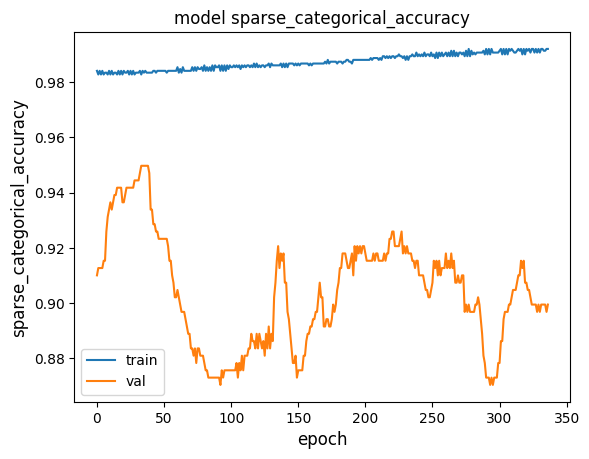

In [77]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [78]:
# Validierung mit dem Neuronalen Netz
model_name = 'best_model'
model.save(f'{model_name}.keras')
model.save(f'{model_name}.h5')
predict_y = model.predict(train_x)

print("'''")
print(f'{model_name}, window_length = {dh.window_length}, epochs = {epochs}, event_ratio = {event_ratio}')
dh.compare_with_testdata(predict_y, train_x, train_y)
print("'''")

60/60 [==============================] - 1s 5ms/step
'''
best_model, window_length = 43, epochs = 1000, event_ratio = 1
+-------------------+-------+---------+-------+---------+
|       device name | total | correct | wrong | percent |
+-------------------+-------+---------+-------+---------+
|  espresso-machine |   378 |     378 |     0 |    100% |
|   washing-machine |   378 |     185 |   193 |     49% |
|       dish-washer |   378 |     371 |     7 |     98% |
|              oven |   378 |     374 |     4 |     99% |
| living-room-light |   378 |     378 |     0 |    100% |
+-------------------+-------+---------+-------+---------+
+-----+-----+-----+-----+-----+-----+
|   0 |   1 |   2 |   3 |   4 |   5 |
+-----+-----+-----+-----+-----+-----+
|   1 | 378 |   0 |   0 |   0 |   0 |
|   2 | 120 | 185 |  59 |  14 |   0 |
|   4 |   7 |   0 | 371 |   0 |   0 |
|  32 |   3 |   0 |   1 | 374 |   0 |
| 256 |   0 |   0 |   0 |   0 | 378 |
+-----+-----+-----+-----+-----+-----+
'''


In [82]:
with h5py.File('best_model_v05_01_bestever.h5', 'r') as f:
    load_weights_from_hdf5_group(f['model_weights'], model.layers)
predict_y = model.predict(train_x)
dh.compare_with_testdata(predict_y, train_x, train_y)

model = keras.models.load_model('best_model_FK_v05_02.keras')
predict_y = model.predict(train_x)
dh.compare_with_testdata(predict_y, train_x, train_y)

model = keras.models.load_model('best_model_FK_v05_03.keras')
predict_y = model.predict(train_x)
dh.compare_with_testdata(predict_y, train_x, train_y)

model = keras.models.load_model('best_model_FK_v05_04.keras')
predict_y = model.predict(train_x)
dh.compare_with_testdata(predict_y, train_x, train_y)

model = keras.models.load_model('best_model_FK_v05_05.keras')
predict_y = model.predict(train_x)
dh.compare_with_testdata(predict_y, train_x, train_y)

model = keras.models.load_model('best_model_FK_v05_06.keras')
predict_y = model.predict(train_x)
dh.compare_with_testdata(predict_y, train_x, train_y)

60/60 [==============================] - 0s 8ms/step
+-------------------+-------+---------+-------+---------+
|       device name | total | correct | wrong | percent |
+-------------------+-------+---------+-------+---------+
|  espresso-machine |   378 |     378 |     0 |    100% |
|   washing-machine |   378 |     240 |   138 |     63% |
|       dish-washer |   378 |     248 |   130 |     66% |
|              oven |   378 |     175 |   203 |     46% |
| living-room-light |   378 |     378 |     0 |    100% |
+-------------------+-------+---------+-------+---------+
+-----+-----+-----+-----+-----+-----+
|   0 |   1 |   2 |   3 |   4 |   5 |
+-----+-----+-----+-----+-----+-----+
|   1 | 378 |   0 |   0 |   0 |   0 |
|   2 | 129 | 240 |   6 |   3 |   0 |
|   4 |   9 | 117 | 248 |   4 |   0 |
|  32 |   9 | 194 |   0 | 175 |   0 |
| 256 |   0 |   0 |   0 |   0 | 378 |
+-----+-----+-----+-----+-----+-----+
60/60 [==============================] - 1s 6ms/step
+-------------------+-------+-